Loaded train.csv: 3000000 rows
After filtering rare labels: 3000000 rows, 22555 classes
Classes: 22555
Loaded tokenization from cache
Vocab size: 489792
Split: 2400000 train / 600000 val
GloVe vectors: 400000
LSTMAttentionClassifier(
  (embedding): Embedding(489792, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attn_lin): Linear(in_features=256, out_features=256, bias=True)
  (attn_vec): Linear(in_features=256, out_features=1, bias=False)
  (fc): Linear(in_features=256, out_features=22555, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)
Epoch 1/10 | Train Loss=0.9252, Acc=74.3%, F1=0.5708 | Val   Loss=1.0292, Acc=72.1%, F1=0.5456
Epoch 2/10 | Train Loss=0.6440, Acc=81.2%, F1=0.6702 | Val   Loss=0.7976, Acc=77.7%, F1=0.6269
Epoch 3/10 | Train Loss=0.5352, Acc=84.0%, F1=0.7160 | Val   Loss=0.7252, Acc=79.7%, F1=0.6611
Epoch 4/10 | Train Loss=0.4714, Acc=85.9%, F1=0.7493 | Val   Loss=0.6964, Acc=80.8%, F1=0.6832
Epoch

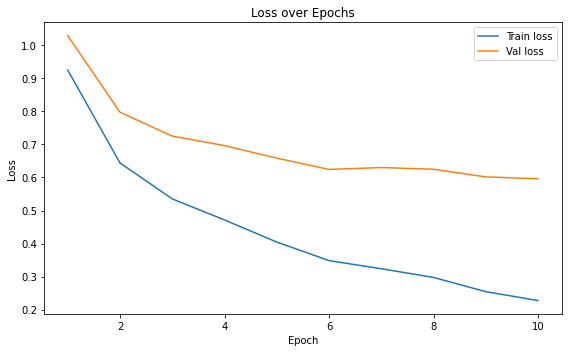

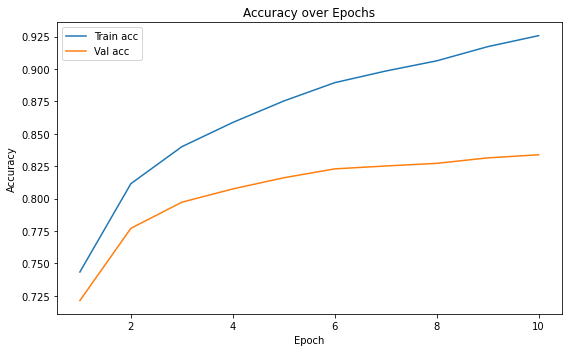

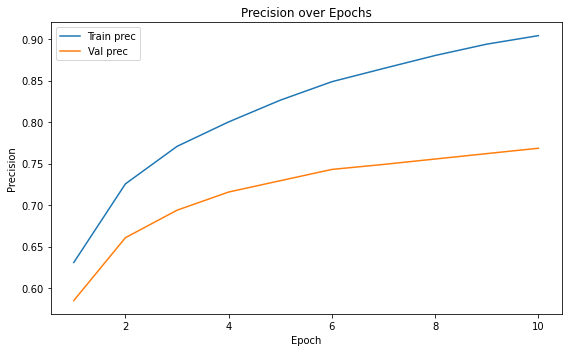

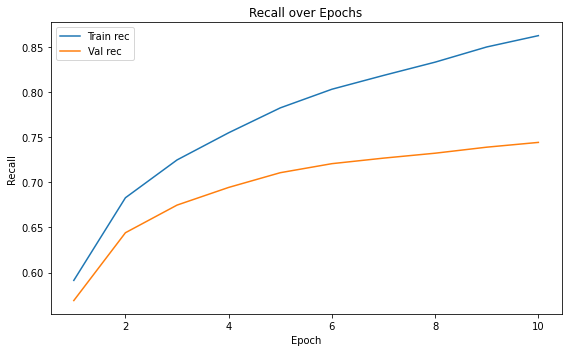

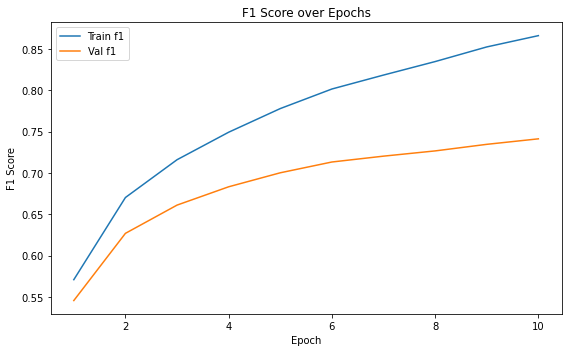

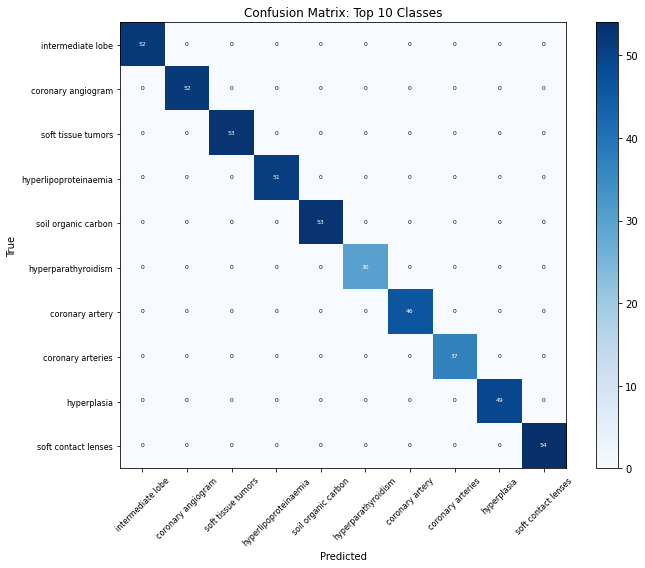

TypeError: predict_abbreviation() got an unexpected keyword argument 'location'

In [ ]:
import os
import zipfile
import random
import pickle
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import spacy

# ────────────────────────────────────────────────────────────────────────────────
# 0. Reproducibility
# ────────────────────────────────────────────────────────────────────────────────
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Project‐relative paths
# ────────────────────────────────────────────────────────────────────────────────
PROJECT_ROOT   = Path(__file__).resolve().parent
DATASET_DIR    = PROJECT_ROOT / "dataset" / "medal" / "pretrain_subset"
TRAIN_CSV      = DATASET_DIR / "train.csv"
TRAIN_ZIP      = DATASET_DIR / "train.csv.zip"
ARCHIVE_ZIP    = PROJECT_ROOT / "archive (3).zip"
MODEL_DIR      = PROJECT_ROOT / "trained_models"
TOKENIZER_DIR  = MODEL_DIR / "tokenizers"
TOK_PATH       = TOKENIZER_DIR / "tokenized_texts.pkl"
EMBEDDING_DIR  = MODEL_DIR / "embeddings" / "pretrained"
GLOVE_PATH     = EMBEDDING_DIR / "glove.6B.100d.txt"

# ────────────────────────────────────────────────────────────────────────────────
# 2. Load spaCy tokenizer (disable parser & NER for speed)
# ────────────────────────────────────────────────────────────────────────────────
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# ────────────────────────────────────────────────────────────────────────────────
# 3. Unzip dataset if needed
# ────────────────────────────────────────────────────────────────────────────────
if not TRAIN_CSV.exists():
    if TRAIN_ZIP.exists():
        with zipfile.ZipFile(str(TRAIN_ZIP), 'r') as z:
            z.extractall(str(DATASET_DIR))
    elif ARCHIVE_ZIP.exists():
        with zipfile.ZipFile(str(ARCHIVE_ZIP), 'r') as z:
            z.extractall(str(DATASET_DIR))
    else:
        raise FileNotFoundError(f"Could not find {TRAIN_CSV.name} or its zip.")

# ────────────────────────────────────────────────────────────────────────────────
# 4. Load the CSV
# ────────────────────────────────────────────────────────────────────────────────
try:
    df = pd.read_csv(str(TRAIN_CSV))
    print(f"Loaded {TRAIN_CSV.name}: {len(df)} rows")
except FileNotFoundError:
    raise RuntimeError(f"{TRAIN_CSV.name} not found; please place it in {DATASET_DIR}")

# ────────────────────────────────────────────────────────────────────────────────
# 5. (Optional) Sample down to 3M rows
# ────────────────────────────────────────────────────────────────────────────────
max_samples = 3_000_000
if len(df) > max_samples:
    df = df.sample(max_samples, random_state=42).reset_index(drop=True)
    print("Sampled down to", len(df))

# ────────────────────────────────────────────────────────────────────────────────
# 6. Clean & filter rare labels
# ────────────────────────────────────────────────────────────────────────────────
df = df.dropna(subset=["TEXT", "LABEL", "LOCATION"])
df["LOCATION"] = df["LOCATION"].astype(int)

label_counts = df["LABEL"].value_counts()
valid_labels = label_counts[label_counts >= 5].index
df = df[df["LABEL"].isin(valid_labels)].reset_index(drop=True)
print("After filtering:", len(df), "rows,", df["LABEL"].nunique(), "classes")

# ────────────────────────────────────────────────────────────────────────────────
# 7. Context extraction
# ────────────────────────────────────────────────────────────────────────────────
def extract_context(text, loc, window_size=50):
    toks  = text.split()
    start = max(0, loc - window_size // 2)
    end   = min(len(toks), loc + window_size // 2)
    return " ".join(toks[start:end])

df["CONTEXT"] = [
    extract_context(t, l) for t, l in zip(df["TEXT"], df["LOCATION"])
]

texts  = df["CONTEXT"].tolist()
labels = df["LABEL"].tolist()

# ────────────────────────────────────────────────────────────────────────────────
# 8. Encode labels
# ────────────────────────────────────────────────────────────────────────────────
le      = LabelEncoder()
y_all   = le.fit_transform(labels)
num_cls = len(le.classes_)
print("Classes:", num_cls)

# ────────────────────────────────────────────────────────────────────────────────
# 9. Tokenization (with caching)
# ────────────────────────────────────────────────────────────────────────────────
if TOKENIZER_DIR.exists() is False:
    TOKENIZER_DIR.mkdir(parents=True)
if TOK_PATH.exists():
    with open(str(TOK_PATH), "rb") as f:
        tokenized_texts = pickle.load(f)
    print("Loaded tokenization cache")
else:
    tokenized_texts = [
        [tok.text for tok in doc if not tok.is_punct and not tok.is_space]
        for doc in nlp.pipe(texts, batch_size=1000)
    ]
    with open(str(TOK_PATH), "wb") as f:
        pickle.dump(tokenized_texts, f)
    print("Tokenization complete and saved")

# ────────────────────────────────────────────────────────────────────────────────
# 10. Build vocabulary & map to indices
# ────────────────────────────────────────────────────────────────────────────────
all_toks = [t for doc in tokenized_texts for t in doc]
vc       = Counter(all_toks)
vocab    = {w for w, c in vc.items() if c >= 2}

word2idx = {"<PAD>": 0, "<UNK>": 1}
for w in sorted(vocab):
    word2idx[w] = len(word2idx)
vocab_size = len(word2idx)
print("Vocab size:", vocab_size)

def tokens_to_seq(ts):
    return [word2idx.get(t, 1) for t in ts]

seqs = [tokens_to_seq(doc) for doc in tokenized_texts]

# ────────────────────────────────────────────────────────────────────────────────
# 11. Pad sequences
# ────────────────────────────────────────────────────────────────────────────────
MAX_LEN = 256
def pad_seq(s):
    return s + [0] * (MAX_LEN - len(s)) if len(s) < MAX_LEN else s[:MAX_LEN]

X_all = np.array([pad_seq(s) for s in seqs])
y_all = np.array(y_all)

# ────────────────────────────────────────────────────────────────────────────────
# 12. Train / Validation split
# ────────────────────────────────────────────────────────────────────────────────
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)
print("Split:", X_tr.shape[0], "train/", X_val.shape[0], "val")

# ────────────────────────────────────────────────────────────────────────────────
# 13. Dataset & DataLoader
# ────────────────────────────────────────────────────────────────────────────────
class MedicalAbbrDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return (
            torch.tensor(self.X[i], dtype=torch.long),
            torch.tensor(self.y[i], dtype=torch.long),
        )

BATCH = 64
train_dl = DataLoader(
    MedicalAbbrDataset(X_tr, y_tr),
    batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True
)
val_dl   = DataLoader(
    MedicalAbbrDataset(X_val, y_val),
    batch_size=BATCH, num_workers=4, pin_memory=True
)

# ────────────────────────────────────────────────────────────────────────────────
# 14. Load GloVe & build embedding matrix
# ────────────────────────────────────────────────────────────────────────────────
def load_glove(fp, dim=100):
    emb = {}
    with open(fp, encoding="utf8") as f:
        for ln in f:
            parts = ln.split()
            w, vec = parts[0], np.array(parts[1:], dtype="float32")
            if vec.shape[0] == dim:
                emb[w] = vec
    return emb

if EMBEDDING_DIR.exists() is False:
    EMBEDDING_DIR.mkdir(parents=True)
if not GLOVE_PATH.exists():
    raise FileNotFoundError(f"{GLOVE_PATH.name} not found; place it in {EMBEDDING_DIR}")

glove = load_glove(str(GLOVE_PATH), 100)
print("GloVe vectors:", len(glove))

emb_mat = np.zeros((vocab_size, 100), dtype="float32")
for w, i in word2idx.items():
    emb_mat[i] = glove.get(w, np.random.normal(scale=0.6, size=(100,)))

# ────────────────────────────────────────────────────────────────────────────────
# 15. Define Attention‐augmented LSTM model
# ────────────────────────────────────────────────────────────────────────────────
class LSTMAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, n_layers, out_dim,
                 dropout=0.3, pretrained=None, freeze_emb=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        if pretrained is not None:
            self.embedding.weight.data.copy_(torch.tensor(pretrained))
            self.embedding.weight.requires_grad = not freeze_emb
        self.lstm = nn.LSTM(
            emb_dim, hid_dim, num_layers=n_layers,
            batch_first=True, bidirectional=True, dropout=dropout
        )
        self.attn_lin = nn.Linear(hid_dim * 2, hid_dim * 2)
        self.attn_vec = nn.Linear(hid_dim * 2, 1, bias=False)
        self.fc       = nn.Linear(hid_dim * 2, out_dim)
        self.drop     = nn.Dropout(dropout)

    def forward(self, x):
        emb, _   = self.embedding(x), None
        lstm_out,_ = self.lstm(emb)
        e        = torch.tanh(self.attn_lin(lstm_out))
        scores   = self.attn_vec(e)                        # [B, L, 1]
        weights  = torch.softmax(scores, dim=1)            # [B, L, 1]
        ctx      = torch.sum(weights * lstm_out, dim=1)    # [B, hid*2]
        ctx      = self.drop(ctx)
        return self.fc(ctx)

HID, LAYERS, DO = 128, 2, 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMAttentionClassifier(
    vocab_size, 100, HID, LAYERS, num_cls,
    dropout=DO, pretrained=emb_mat, freeze_emb=False
).to(device)
print(model)

# ────────────────────────────────────────────────────────────────────────────────
# 16. Loss, optimizer & utils
# ────────────────────────────────────────────────────────────────────────────────
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def compute_metrics(model, dl):
    model.eval()
    total_loss, correct = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for Xb, yb in dl:
            Xb, yb = Xb.to(device), yb.to(device)
            out    = model(Xb)
            loss   = criterion(out, yb)
            total_loss += loss.item() * Xb.size(0)
            pred  = out.argmax(1)
            correct   += (pred == yb).sum().item()
            all_preds.extend(pred.cpu().tolist())
            all_labels.extend(yb.cpu().tolist())
    N = len(dl.dataset)
    return (total_loss / N, correct / N,
            precision_score(all_labels, all_preds, average="macro", zero_division=0),
            recall_score(all_labels, all_preds, average="macro", zero_division=0),
            f1_score(all_labels, all_preds, average="macro", zero_division=0),
            all_preds, all_labels)

def train_one_epoch(model, dl):
    model.train()
    running_loss, running_correct = 0.0, 0
    for Xb, yb in dl:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out   = model(Xb)
        loss  = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss    += loss.item() * Xb.size(0)
        running_correct += (out.argmax(1) == yb).sum().item()
    N = len(dl.dataset)
    return running_loss / N, running_correct / N

# ────────────────────────────────────────────────────────────────────────────────
# 17. Training loop
# ────────────────────────────────────────────────────────────────────────────────
EPOCHS = 10
history = {k: [] for k in [
    'train_loss','train_acc','train_prec','train_rec','train_f1',
    'val_loss','val_acc','val_prec','val_rec','val_f1'
]}

for ep in range(1, EPOCHS+1):
    tl, ta = train_one_epoch(model, train_dl)
    vl, va, vp, vr, vf, vpreds, vlabels = compute_metrics(model, val_dl)
    tr, tacc, tp, trc, tf, _, _ = compute_metrics(model, train_dl)

    history['train_loss'].append(tr)
    history['train_acc'].append(tacc)
    history['train_prec'].append(tp)
    history['train_rec'].append(trc)
    history['train_f1'].append(tf)

    history['val_loss'].append(vl)
    history['val_acc'].append(va)
    history['val_prec'].append(vp)
    history['val_rec'].append(vr)
    history['val_f1'].append(vf)

    print(f"Epoch {ep}/{EPOCHS} | "
          f"Train: loss={tr:.4f}, acc={tacc*100:.1f}%, f1={tf:.4f} | "
          f"Val:   loss={vl:.4f}, acc={va*100:.1f}%, f1={vf:.4f}")

# ────────────────────────────────────────────────────────────────────────────────
# 18. Plot metrics
# ────────────────────────────────────────────────────────────────────────────────
epochs = np.arange(1, EPOCHS+1)
metrics = [
    ('train_loss','Loss'), ('train_acc','Accuracy'),
    ('train_prec','Precision'), ('train_rec','Recall'),
    ('train_f1','F1 Score')
]
for key, title in metrics:
    plt.figure(figsize=(8,5))
    plt.plot(epochs, history[key], label=f"Train {title}")
    plt.plot(epochs, history[f"val_{key.split('_')[1]}"], label=f"Val {title}")
    plt.title(f"{title} over Epochs")
    plt.xlabel("Epoch"); plt.ylabel(title)
    plt.legend(); plt.tight_layout(); plt.show()

# ────────────────────────────────────────────────────────────────────────────────
# 19. Confusion matrix (top 10)
# ────────────────────────────────────────────────────────────────────────────────
TOP_N    = 10
_,_,_,_,_, vpreds, vlabels = compute_metrics(model, val_dl)
cm       = confusion_matrix(vlabels, vpreds)
freqs    = np.bincount(vlabels, minlength=num_cls)
top_idxs = np.argsort(freqs)[::-1][:TOP_N]
cm_sub   = cm[top_idxs][:, top_idxs]
lbls_sub = le.inverse_transform(top_idxs)

plt.figure(figsize=(10,8))
plt.imshow(cm_sub, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: Top {TOP_N} Classes")
plt.colorbar()
ticks = np.arange(TOP_N)
plt.xticks(ticks, lbls_sub, rotation=45, fontsize=8)
plt.yticks(ticks, lbls_sub, fontsize=8)
th = cm_sub.max() / 2
for i in range(TOP_N):
    for j in range(TOP_N):
        plt.text(j, i, cm_sub[i, j],
                 ha="center",
                 color="white" if cm_sub[i, j] > th else "black",
                 fontsize=6)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# ────────────────────────────────────────────────────────────────────────────────
# 20. Inference helper
# ────────────────────────────────────────────────────────────────────────────────
def predict_abbreviation(model, text, loc):
    ctx  = extract_context(text, loc, window_size=50)
    toks = [t.text for t in nlp(ctx) if not t.is_punct and not t.is_space]
    seq  = [word2idx.get(t, 1) for t in toks]
    seq  = pad_seq(seq)
    inp  = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(inp)
    cls = out.argmax(1).item()
    return le.inverse_transform([cls])[0]

# Example inference
example_text     = "The patient was diagnosed with acute MI and was admitted to the ICU for monitoring."
example_location = 6
print("Predicted expansion:", predict_abbreviation(model, example_text, example_location))

In [ ]:
from pathlib import Path

# ────────────────────────────────────────────────────────────────────────────────
# Save the trained model into your project’s trained_models directory
# ────────────────────────────────────────────────────────────────────────────────
MODEL_DIR = PROJECT_ROOT / "trained_models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

model_save_path = MODEL_DIR / "trained_model_LSTM_Attention.pth"
torch.save(model.state_dict(), str(model_save_path))

print(f"Model saved to {model_save_path}")

Model saved to trained_model_LSTM_Attention.pth


In [5]:
from collections import Counter
from sklearn.metrics import classification_report

# Count how many true samples per class
counts = Counter(vlabels)
# Choose top N most frequent class indices
top_n = 30
top_classes = [cls for cls, _ in counts.most_common(top_n)]
top_names   = [le.classes_[cls] for cls in top_classes]

# Generate a pruned classification report
report = classification_report(
    vlabels,
    vpreds,
    labels=top_classes,
    target_names=top_names,
    zero_division=0
)
print(f"Classification Report for Top {top_n} Classes:\n")
print(report)

Classification Report for Top 30 Classes:

                                         precision    recall  f1-score   support

                simple sequence repeats       0.96      0.98      0.97        54
                              c peptide       0.43      0.69      0.52        54
                         verylowdensity       1.00      0.96      0.98        54
                   maximal electroshock       0.91      0.96      0.94        54
                               approach       0.77      0.93      0.84        54
                   toxic shock syndrome       0.95      0.98      0.96        54
                               headache       0.67      0.65      0.66        54
      diagnostic and statistical manual       0.98      1.00      0.99        54
                      actinic keratosis       0.95      0.96      0.95        54
                           sleep apnoea       0.49      0.57      0.53        54
transurethral resection of the prostate       0.58      0.83     

In [6]:
from collections import Counter
from sklearn.metrics import classification_report

# Count how many true samples per class
counts = Counter(vlabels)
# Choose top N most frequent class indices
top_n = 10
top_classes = [cls for cls, _ in counts.most_common(top_n)]
top_names   = [le.classes_[cls] for cls in top_classes]

# Generate a pruned classification report
report = classification_report(
    vlabels,
    vpreds,
    labels=top_classes,
    target_names=top_names,
    zero_division=0
)
print(f"Classification Report for Top {top_n} Classes:\n")
print(report)

Classification Report for Top 10 Classes:

                                   precision    recall  f1-score   support

          simple sequence repeats       0.96      0.98      0.97        54
                        c peptide       0.43      0.69      0.52        54
                   verylowdensity       1.00      0.96      0.98        54
             maximal electroshock       0.91      0.96      0.94        54
                         approach       0.77      0.93      0.84        54
             toxic shock syndrome       0.95      0.98      0.96        54
                         headache       0.67      0.65      0.66        54
diagnostic and statistical manual       0.98      1.00      0.99        54
                actinic keratosis       0.95      0.96      0.95        54
                     sleep apnoea       0.49      0.57      0.53        54

                        micro avg       0.79      0.87      0.82       540
                        macro avg       0.81      0.87 

In [ ]:
from pathlib import Path

# ────────────────────────────────────────────────────────────────────────────────
# Ensure your trained_models directory exists (reuse MODEL_DIR from above)
# ────────────────────────────────────────────────────────────────────────────────
REPORT_DIR = PROJECT_ROOT / "trained_models"
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# Generate and save the full classification report
# ────────────────────────────────────────────────────────────────────────────────
from sklearn.metrics import classification_report

full_report = classification_report(
    vlabels,
    vpreds,
    target_names=le.classes_,
    zero_division=0
)

report_path = REPORT_DIR / "classification_report.txt"
with open(report_path, "w") as f:
    f.write(full_report)

print(f"Full classification report saved to {report_path}")

Full classification report saved to classification_report.txt


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle
import spacy
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from pathlib import Path

# ────────────────────────────────────────────────────────────────────────────────
# 1) Define project‐relative constants and paths
# ────────────────────────────────────────────────────────────────────────────────
PROJECT_ROOT   = Path(__file__).resolve().parent
DATASET_DIR    = PROJECT_ROOT / "dataset" / "medal" / "pretrain_subset"
MODEL_DIR      = PROJECT_ROOT / "trained_models"
TOKENIZER_DIR  = MODEL_DIR / "tokenizers"
EMBEDDING_DIR  = MODEL_DIR / "embeddings" / "pretrained"

TRAIN_CSV      = DATASET_DIR / "train.csv"
TOK_PKL        = TOKENIZER_DIR / "tokenized_texts.pkl"
GLOVE_FILE     = EMBEDDING_DIR / "glove.6B.100d.txt"
MODEL_FILE     = MODEL_DIR / "trained_model_LSTM_Attention.pth"

HID, LAYERS, DO = 128, 2, 0.3
EMB_DIM, MAX_LEN = 100, 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ────────────────────────────────────────────────────────────────────────────────
# 2) Ensure directories exist
# ────────────────────────────────────────────────────────────────────────────────
TOKENIZER_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# 3) Load spaCy tokenizer (disable parser & NER)
# ────────────────────────────────────────────────────────────────────────────────
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# ────────────────────────────────────────────────────────────────────────────────
# 4) Load CSV and filter labels
# ────────────────────────────────────────────────────────────────────────────────
df = pd.read_csv(str(TRAIN_CSV))
df = df.dropna(subset=["TEXT", "LABEL", "LOCATION"])
df["LOCATION"] = df["LOCATION"].astype(int)

label_counts = df["LABEL"].value_counts()
valid_labels = label_counts[label_counts >= 5].index
df = df[df["LABEL"].isin(valid_labels)].reset_index(drop=True)

le    = LabelEncoder().fit(df["LABEL"])
num_cls = len(le.classes_)

# ────────────────────────────────────────────────────────────────────────────────
# 5) Load tokenized texts from cache
# ────────────────────────────────────────────────────────────────────────────────
with open(str(TOK_PKL), "rb") as f:
    tokenized_texts = pickle.load(f)

# ────────────────────────────────────────────────────────────────────────────────
# 6) Build vocabulary
# ────────────────────────────────────────────────────────────────────────────────
all_tokens = [t for doc in tokenized_texts for t in doc]
vc         = Counter(all_tokens)
vocab      = {w for w, c in vc.items() if c >= 2}

word2idx   = {"<PAD>": 0, "<UNK>": 1}
for w in sorted(vocab):
    word2idx[w] = len(word2idx)
vocab_size = len(word2idx)

# ────────────────────────────────────────────────────────────────────────────────
# 7) Load GloVe embeddings
# ────────────────────────────────────────────────────────────────────────────────
def load_glove(fp, dim=EMB_DIM):
    emb = {}
    with open(fp, encoding="utf8") as f:
        for ln in f:
            parts = ln.split()
            w, vec = parts[0], np.array(parts[1:], dtype="float32")
            if vec.shape[0] == dim:
                emb[w] = vec
    return emb

glove_index = load_glove(str(GLOVE_FILE))
emb_mat      = np.zeros((vocab_size, EMB_DIM), dtype="float32")
for w, i in word2idx.items():
    emb_mat[i] = glove_index.get(w, np.random.normal(scale=0.6, size=(EMB_DIM,)))

# ────────────────────────────────────────────────────────────────────────────────
# 8) Define model class
# ────────────────────────────────────────────────────────────────────────────────
class LSTMAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, n_layers, out_dim, dropout=0.3,
                 pretrained=None, freeze_emb=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        if pretrained is not None:
            self.embedding.weight.data.copy_(torch.tensor(pretrained))
            self.embedding.weight.requires_grad = not freeze_emb
        self.lstm     = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers,
                                batch_first=True, bidirectional=True, dropout=dropout)
        self.attn_lin = nn.Linear(hid_dim * 2, hid_dim * 2)
        self.attn_vec = nn.Linear(hid_dim * 2, 1, bias=False)
        self.fc       = nn.Linear(hid_dim * 2, out_dim)
        self.drop     = nn.Dropout(dropout)

    def forward(self, x):
        emb      = self.embedding(x)
        lstm_out, _ = self.lstm(emb)
        e        = torch.tanh(self.attn_lin(lstm_out))
        scores   = self.attn_vec(e)                   # [B, L, 1]
        weights  = torch.softmax(scores, dim=1)       # [B, L, 1]
        ctx      = torch.sum(weights * lstm_out, dim=1)
        return self.fc(self.drop(ctx))

# ────────────────────────────────────────────────────────────────────────────────
# 9) Load trained model
# ────────────────────────────────────────────────────────────────────────────────
model = LSTMAttentionClassifier(
    vocab_size, EMB_DIM, HID, LAYERS, num_cls, DO,
    pretrained=emb_mat, freeze_emb=False
).to(device)

model.load_state_dict(torch.load(str(MODEL_FILE), map_location=device))
model.eval()

# ────────────────────────────────────────────────────────────────────────────────
# 10) Inference helpers
# ────────────────────────────────────────────────────────────────────────────────
def extract_context(text, loc, window_size=50):
    toks  = text.split()
    start = max(0, loc - window_size // 2)
    end   = min(len(toks), loc + window_size // 2)
    return " ".join(toks[start:end])

def pad_seq(s):
    return s + [0] * (MAX_LEN - len(s)) if len(s) < MAX_LEN else s[:MAX_LEN]

def predict_abbreviation(model, text, loc):
    ctx  = extract_context(text, loc)
    toks = [t.text for t in nlp(ctx) if not t.is_punct and not t.is_space]
    seq  = pad_seq([word2idx.get(t, 1) for t in toks])
    inp  = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(inp)
    cls = out.argmax(1).item()
    return le.inverse_transform([cls])[0]

# ────────────────────────────────────────────────────────────────────────────────
# 11) Example usage
# ────────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    example_text     = "The patient was diagnosed with acute MI and was admitted to the ICU for monitoring."
    example_location = 6
    prediction = predict_abbreviation(model, example_text, example_location)
    print("Predicted expansion:", prediction)

Predicted expansion: meconium ileus


In [12]:
# Define test cases as (text, location) tuples for clarity
test_cases = [
    ("The patient was diagnosed with deep vein thrombosis, also known as DVT, and started on anticoagulants.", 10),
    ("Following a heart attack, the patient underwent CABG to restore blood flow.", 7),
    ("A CT scan was performed to evaluate internal injuries after the car crash.", 1),
    ("Due to persistent seizures, an EEG was conducted to analyze brain activity.", 8),
    ("The IV line was inserted to administer fluids and medications.", 1),
    ("The doctor reviewed the ECG, which showed signs of arrhythmia.", 4),
    ("She experienced a TIA last year, which resolved within minutes without lasting damage.", 3),
    ("After a stroke, the patient was admitted to the ICU for close monitoring.", 8),
    ("MRI results indicated no abnormalities in the brain structure.", 0),
    ("The ER staff stabilized the patient before moving him to a regular ward.", 1)
]

# Run predictions
for idx, (text, location) in enumerate(test_cases, 1):
    prediction = predict_abbreviation(model, text, location)
    print(f"Test {idx}:")
    print(f"Text: '{text}'")
    print(f"Abbreviation token index: {location}")
    print(f"Predicted Expansion: {prediction}\n")

Test 1:
Text: 'The patient was diagnosed with deep vein thrombosis, also known as DVT, and started on anticoagulants.'
Abbreviation token index: 10
Predicted Expansion: deep vein thromboses

Test 2:
Text: 'Following a heart attack, the patient underwent CABG to restore blood flow.'
Abbreviation token index: 7
Predicted Expansion: coronary artery bypass grafting

Test 3:
Text: 'A CT scan was performed to evaluate internal injuries after the car crash.'
Abbreviation token index: 1
Predicted Expansion: computerized tomographic

Test 4:
Text: 'Due to persistent seizures, an EEG was conducted to analyze brain activity.'
Abbreviation token index: 8
Predicted Expansion: brain electrical activity

Test 5:
Text: 'The IV line was inserted to administer fluids and medications.'
Abbreviation token index: 1
Predicted Expansion: diagnostic and statistical manual of mental disorders fourth edition

Test 6:
Text: 'The doctor reviewed the ECG, which showed signs of arrhythmia.'
Abbreviation token index

In [ ]:
from pathlib import Path
import pickle

# ────────────────────────────────────────────────────────────────────────────────
# 1) Define where to save your tokenization artifacts
# ────────────────────────────────────────────────────────────────────────────────
PROJECT_ROOT  = Path(__file__).resolve().parent
TOKENIZER_DIR = PROJECT_ROOT / "trained_models" / "tokenizers"
TOKENIZER_DIR.mkdir(parents=True, exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# 2) Save word2idx
# ────────────────────────────────────────────────────────────────────────────────
word2idx_path = TOKENIZER_DIR / "word2idx.pkl"
with open(word2idx_path, "wb") as f:
    pickle.dump(word2idx, f)
print(f"Saved word2idx to {word2idx_path}")

# ────────────────────────────────────────────────────────────────────────────────
# 3) Save label encoder
# ────────────────────────────────────────────────────────────────────────────────
le_path = TOKENIZER_DIR / "label_encoder.pkl"
with open(le_path, "wb") as f:
    pickle.dump(le, f)
print(f"Saved label encoder to {le_path}")

Saved word2idx.pkl
Saved label_encoder.pkl
